In [1]:
code_folder = '../codes'
import sys
sys.path.append(code_folder)


In [2]:
import numpy as np
from rdkit import RDLogger    
from torch_geometric.data import Data
RDLogger.DisableLog('rdApp.*')
from util_gnn import draw_graph
from torch_geometric.data import DataLoader
import torch

In [4]:
### Load data
batch_size = 64
mol_data = torch.load('zinc_smiles_noar.pt')
data_list = torch.load('zinc_data_noar.pt')
data_loader = DataLoader(data_list, batch_size=batch_size, shuffle=True, follow_batch=['edge_index', 'y'])

/home/miniconda3/envs/gnn/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
len(data_list)

249456

In [8]:
import os
generator = torch.load('../models/ul_gan_zinc.pt')

In [12]:
from trainer import generate_noise
from util_molecular import MolFromTorchGraphData_enriched, evaluate


In [13]:
evaluate_num = 10000
rand_dim = 128
device = 'cpu'

In [14]:
z_rand, z_lr_cont, z_cate, z_cont = generate_noise(device=device, rand_dim=128)
z = z_rand

In [15]:
generator.eval()
all_eval_res = []
for j in range(100):
    with torch.no_grad():
        eval_fake_data = []
        problem_info = []
        for j in range(evaluate_num//batch_size):
            z_rand, z_lr_cont, z_cate, z_cont = generate_noise(device=device, rand_dim=rand_dim)
            z = z_rand
            fake_data, probs = generator(z)
            eval_fake_data.extend([fake_data[j] for j in range(fake_data.batch.max().item() + 1)])
        eval_fake_data = [MolFromTorchGraphData_enriched(j.to('cpu'), without_aroma=True) for j in eval_fake_data]
        eval_res = evaluate(eval_fake_data, mol_data, eval_two=True)
        all_eval_res.append(eval_res)
        print ("Validation, uniqueness, novelty: ", eval_res) 

_ = generator.train()


/data/unpool/unpool_layers_simple_v2.py:996: UserWarning: There is no 'use_softmax' attribute in the class, we just use True as default
  warnings.warn("There is no 'use_softmax' attribute in the class, we just use True as default")


Uniqueness at 1k, 10k 1.0 0.9997710098465766
Validation, uniqueness, novelty:  (0.8747996794871795, 0.9997710098465766, 1.0)
Uniqueness at 1k, 10k 1.0 0.9997699827487061
Validation, uniqueness, novelty:  (0.8708934294871795, 0.9997699827487061, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8705929487179487, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8682892628205128, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 0.9998853868194842
Validation, uniqueness, novelty:  (0.8738982371794872, 0.9998853868194842, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8737980769230769, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 0.9998857142857143
Validation, uniqueness, novelty:  (0.8764022435897436, 0.9998857142857143, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8713942307692307, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8734975961538461, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0

Validation, uniqueness, novelty:  (0.8725961538461539, 0.9998852157943067, 1.0)
Uniqueness at 1k, 10k 1.0 0.9997706947947719
Validation, uniqueness, novelty:  (0.8735977564102564, 0.9997706947947719, 1.0)
Uniqueness at 1k, 10k 1.0 0.9998848854610337
Validation, uniqueness, novelty:  (0.8700921474358975, 0.9998848854610337, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8728966346153846, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8690905448717948, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8660857371794872, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8742988782051282, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.8681891025641025, 1.0, 1.0)
Uniqueness at 1k, 10k 1.0 0.9998854130858256
Validation, uniqueness, novelty:  (0.8740985576923077, 0.9998854130858256, 1.0)
Uniqueness at 1k, 10k 1.0 1.0
Validation, uniqueness, novelty:  (0.871

KeyboardInterrupt: 

In [16]:
len(all_eval_res)

92

In [18]:
np.array(all_eval_res).mean(axis=0).round(3), np.array(all_eval_res).std(axis=0).round(3)

(array([0.871, 1.   , 1.   ]), array([0.004, 0.   , 0.   ]))

In [52]:
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

eval_valid_data = [Chem.MolFromSmiles(Chem.MolToSmiles(j)) for j in eval_fake_data if Chem.MolFromSmiles(Chem.MolToSmiles(j)) is not None]


4


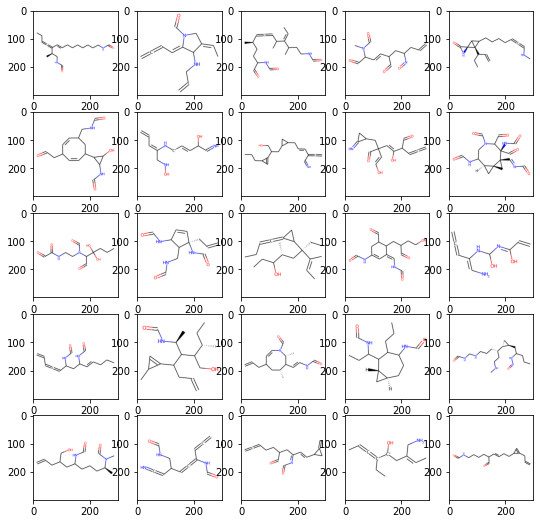

In [73]:
%matplotlib inline
folder = 'figure_zinc'
if not os.path.exists(os.path.join(folder, f'fake_ulgan')):
    os.mkdir(os.path.join(folder, f'fake_ulgan'))

fig, ax = plt.subplots(5, 5, figsize=(9, 9))
test_num = np.random.randint(len(eval_valid_data) - 30)
test_num = 4
print (test_num)
for j in range(256):
    fig = Draw.MolToImage(eval_valid_data[test_num + j])
    fig.save(os.path.join(folder, f'fake_ulgan', 'Fake_graph_%d_epoch%d.png' % (j, test_num)))

for i in range(5):
    for j in range(5):
        ax[i, j].imshow(Draw.MolToImage(eval_valid_data[test_num+j+i*5]))

# _ = generator.train()


In [77]:
from util_seq_genereation import sequential_generation_zinc

In [78]:
tf1, tf2, tf3, tf4, tf5, tf6 = [], [], [], [], [], []


In [79]:
z_rand, z_lr_cont, z_cate, z_cont = generate_noise(device=device, rand_dim=128)
z = z_rand

generator.eval()
with torch.no_grad():
    f1, f2, f3, f4, f5, f6 = sequential_generation_zinc(generator, z)
_ = generator.train()
f1, f2, f3, f4, f5, f6 = f1.cpu(), f2.cpu(), f3.cpu(), f4.cpu(), f5.cpu(), f6.cpu()

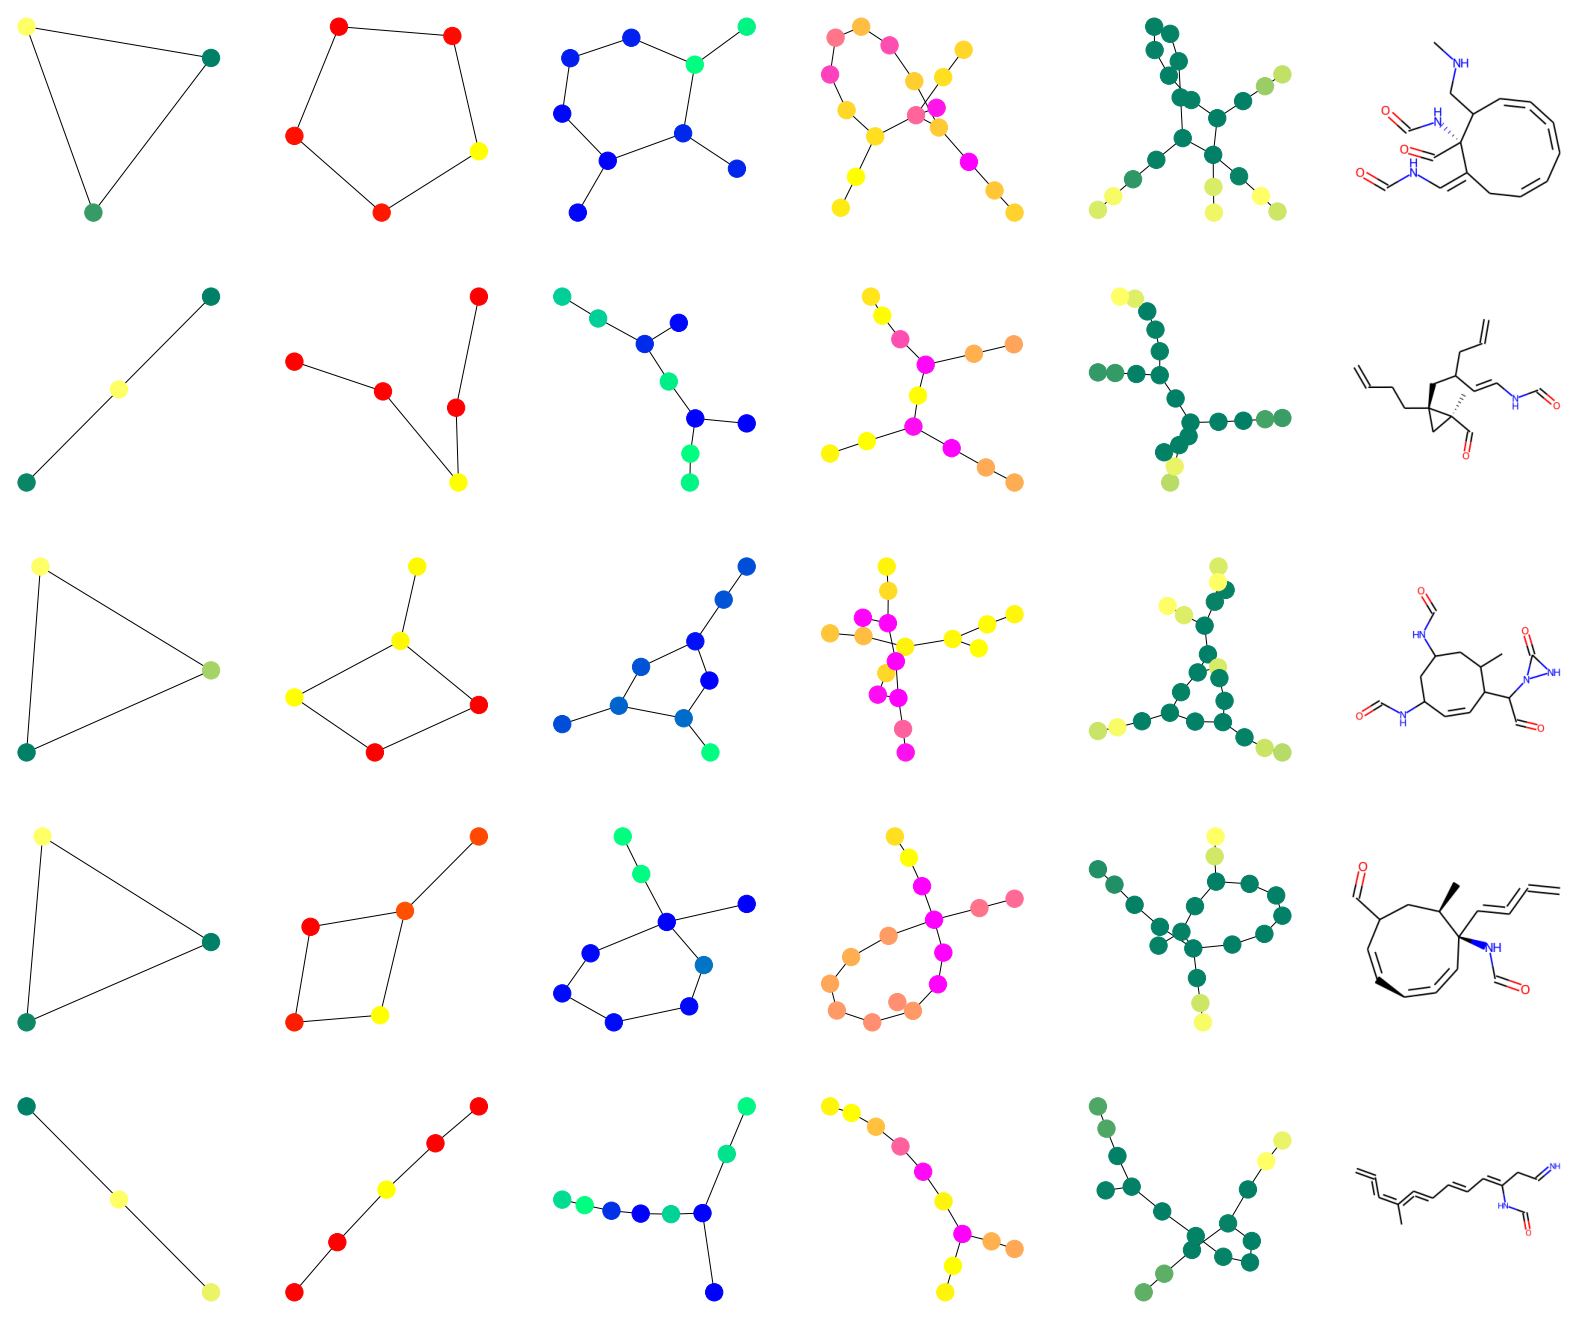

In [119]:
%matplotlib inline
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

figs, axs = plt.subplots(5, 6, figsize=(28, 24))
i = 0
for ii in range(5):
    if Chem.MolFromSmiles(Chem.MolToSmiles(MolFromTorchGraphData_enriched(f6[i], without_aroma=True))) is None:
        i += 1
    j = 0
    draw_graph(f1[i], node_code=False, ax=axs[ii, j], cmaps='summer', node_size=50)
    j = 1
    draw_graph(f2[i], node_code=False, ax=axs[ii, j], cmaps='autumn', node_size=50)
    j = 2
    draw_graph(f3[i], node_code=False, ax=axs[ii, j], cmaps='winter', node_size=50)
    j = 3
    draw_graph(f4[i], node_code=False, ax=axs[ii, j], cmaps='spring', node_size=50)
    j = 4
    draw_graph(f5[i], node_code=False, ax=axs[ii, j], cmaps='summer', node_size=50)
    j = 5
    axs[ii, j].imshow(Draw.MolToImage(MolFromTorchGraphData_enriched(f6[i], without_aroma=True)), aspect='auto')
    i += 1
    axs[ii, j].set_axis_off()
    
